In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph Session06 - Multi Agent RAG"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from typing import TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()

In [2]:
# 1. Define State
class PostState(TypedDict):
    messages: list
    summary: str
    post: str
    verify_result: Literal["pass", "revise"]
    revision_count: int
    tech_check: str
    style_check: str
    next_agent: str  # Added for supervisor routing

In [3]:
# 2. Define Tools
@tool
def mock_paper_lookup(title: str) -> str:
    """Simulate paper retrieval and return a short abstract."""
    return (
        "LoRA is a low-rank adaptation technique for fine-tuning large language models. "
        "It enables efficient training by injecting low-rank matrices into transformer weights."
    )

@tool
def verify_technical_correctness(summary: str) -> str:
    """Returns 'pass' or 'revise' for technical accuracy (simulated)."""
    return "pass" if "LoRA" in summary else "revise"

@tool
def check_social_post_style(post: str) -> str:
    """Check post for platform-appropriate style. Simulated."""
    if len(post) > 300 or "@AIMakerspace" not in post:
        return "revise"
    return "pass"

In [4]:
# 3. Define Agent Executors
llm = ChatOpenAI(model="gpt-4o")

def create_tool_agent(system_prompt: str, tools: list):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder("messages"),
        MessagesPlaceholder("agent_scratchpad"),
    ])
    agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=prompt)
    return AgentExecutor(agent=agent, tools=tools)

def create_prompt_only_agent(system_prompt: str, output_key: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    chain = prompt | llm

    def run(state: dict):
        # Ensure messages is a proper list of LangChain message objects
        messages = state.get("messages", [])
        if not isinstance(messages, list):
            raise ValueError("Expected 'messages' to be a list")
        response = chain.invoke({"messages": messages})
        return {
            **state,
            output_key: response.content
        }

    return RunnableLambda(run)


In [5]:
# 4. Agents
research_agent = create_tool_agent(
    "You are a researcher. Use available tools to find ML paper content.", [mock_paper_lookup]
)

summarize_agent = create_prompt_only_agent(
    "You are a scientific summarizer. Generate a short, accurate summary.", "summary"
)

post_agent = create_prompt_only_agent(
    "You are a social media strategist. Write a LinkedIn post using the summary. The post MUST mention @AIMakerspace and MUST be under 300 characters. If you are revising, make sure to fix any issues with these requirements.",
    "post"
)

verify_agent = create_tool_agent(
    "You are a verification team. Check both accuracy and platform style.", 
    [verify_technical_correctness, check_social_post_style]
)

def verify_wrapper(state):
    summary = state.get("summary", "")
    post = state.get("post", "")
    tech_result = verify_technical_correctness.invoke(summary)
    style_result = check_social_post_style.invoke(post)
    revision_count = state.get("revision_count", 0)
    if tech_result == "pass" and style_result == "pass":
        verify_result = "pass"
        next_agent = "FINISH"
    elif revision_count >= 3:
        verify_result = "pass"
        next_agent = "FINISH"
    else:
        verify_result = "revise"
        next_agent = "supervisor"
    return {
        **state,
        "verify_result": verify_result,
        "revision_count": revision_count + 1,
        "tech_check": tech_result,
        "style_check": style_result,
        "next_agent": next_agent
    }

verify_node = RunnableLambda(verify_wrapper)

# 5. Supervisor Agent
supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a supervisor that coordinates a team of agents working on creating LinkedIn posts from research papers.

Your team consists of:
- research: Finds and retrieves paper content
- summarize: Creates scientific summaries 
- draft_post: Writes social media posts
- verify: Checks technical accuracy and style

Based on the current state and any feedback, decide which agent should work next.

Rules:
1. Always start with 'research' if no summary exists
2. After research, go to 'summarize' 
3. After summarize, go to 'draft_post'
4. After draft_post, go to 'verify'
5. If verify fails and revision_count < 3, decide between 'summarize' or 'draft_post' based on what needs fixing
6. If technical check failed, go to 'summarize'
7. If style check failed, go to 'draft_post'
8. If both failed, go to 'draft_post' (it can handle both issues)
9. If verify passes or revision_count >= 3, return 'FINISH'

Current state summary:
- Summary exists: {summary_exists}
- Post exists: {post_exists}
- Technical check: {tech_check}
- Style check: {style_check}
- Revision count: {revision_count}
- Verify result: {verify_result}

Respond with ONLY the name of the next agent: research, summarize, draft_post, verify, or FINISH"""),
    MessagesPlaceholder("messages")
])

def supervisor_node(state):
    summary = state.get("summary", "")
    post = state.get("post", "")
    tech_check = state.get("tech_check", "")
    style_check = state.get("style_check", "")
    revision_count = state.get("revision_count", 0)
    verify_result = state.get("verify_result", "")
    messages = state.get("messages", [])
    
    # Determine next agent based on current state
    if not summary:
        next_agent = "research"
    elif not post:
        next_agent = "summarize" if summary and not post else "research"
    elif verify_result == "":
        next_agent = "verify"
    elif verify_result == "revise" and revision_count < 3:
        if tech_check == "revise":
            next_agent = "summarize"
        elif style_check == "revise":
            next_agent = "draft_post"
        else:
            next_agent = "draft_post"
    else:
        next_agent = "FINISH"
    
    # For complex decisions, use LLM
    if verify_result == "revise" and tech_check == "revise" and style_check == "revise":
        supervisor_chain = supervisor_prompt | llm
        response = supervisor_chain.invoke({
            "messages": messages,
            "summary_exists": bool(summary),
            "post_exists": bool(post),
            "tech_check": tech_check,
            "style_check": style_check,
            "revision_count": revision_count,
            "verify_result": verify_result
        })
        next_agent = response.content.strip()
    
    return {**state, "next_agent": next_agent}

In [6]:
# 6. Routers
def supervisor_router(state: PostState):
    """Routes to the next agent as determined by supervisor"""
    return state["next_agent"]

def agent_node_wrapper(agent_func, node_name):
    """Wrapper that adds supervisor routing after agent execution"""
    def wrapped_node(state):
        # Execute the agent
        result = agent_func(state)
        # Add supervisor decision
        supervisor_result = supervisor_node(result)
        return supervisor_result
    return wrapped_node

In [7]:
# 7. Define Supervisor Graph
graph = StateGraph(PostState)

# Add supervisor as the central coordinator
graph.add_node("supervisor", supervisor_node)

# Add agent nodes wrapped with supervisor routing
graph.add_node("research", agent_node_wrapper(research_agent, "research"))
graph.add_node("summarize", agent_node_wrapper(summarize_agent, "summarize"))
graph.add_node("draft_post", agent_node_wrapper(post_agent, "draft_post"))
graph.add_node("verify", verify_node)  # verify already includes supervisor routing

# Set entry point to supervisor
graph.set_entry_point("supervisor")

# Add conditional edges from supervisor to all agents
graph.add_conditional_edges(
    "supervisor",
    supervisor_router,
    {
        "research": "research",
        "summarize": "summarize", 
        "draft_post": "draft_post",
        "verify": "verify",
        "FINISH": END
    }
)

# All agents route back to supervisor (except when finishing)
graph.add_conditional_edges(
    "research",
    supervisor_router,
    {
        "research": "research",
        "summarize": "summarize",
        "draft_post": "draft_post", 
        "verify": "verify",
        "FINISH": END
    }
)

graph.add_conditional_edges(
    "summarize",
    supervisor_router,
    {
        "research": "research",
        "summarize": "summarize",
        "draft_post": "draft_post",
        "verify": "verify", 
        "FINISH": END
    }
)

graph.add_conditional_edges(
    "draft_post",
    supervisor_router,
    {
        "research": "research",
        "summarize": "summarize",
        "draft_post": "draft_post",
        "verify": "verify",
        "FINISH": END
    }
)

graph.add_conditional_edges(
    "verify",
    supervisor_router,
    {
        "supervisor": "supervisor",
        "FINISH": END
    }
)

supervisor_graph = graph.compile()

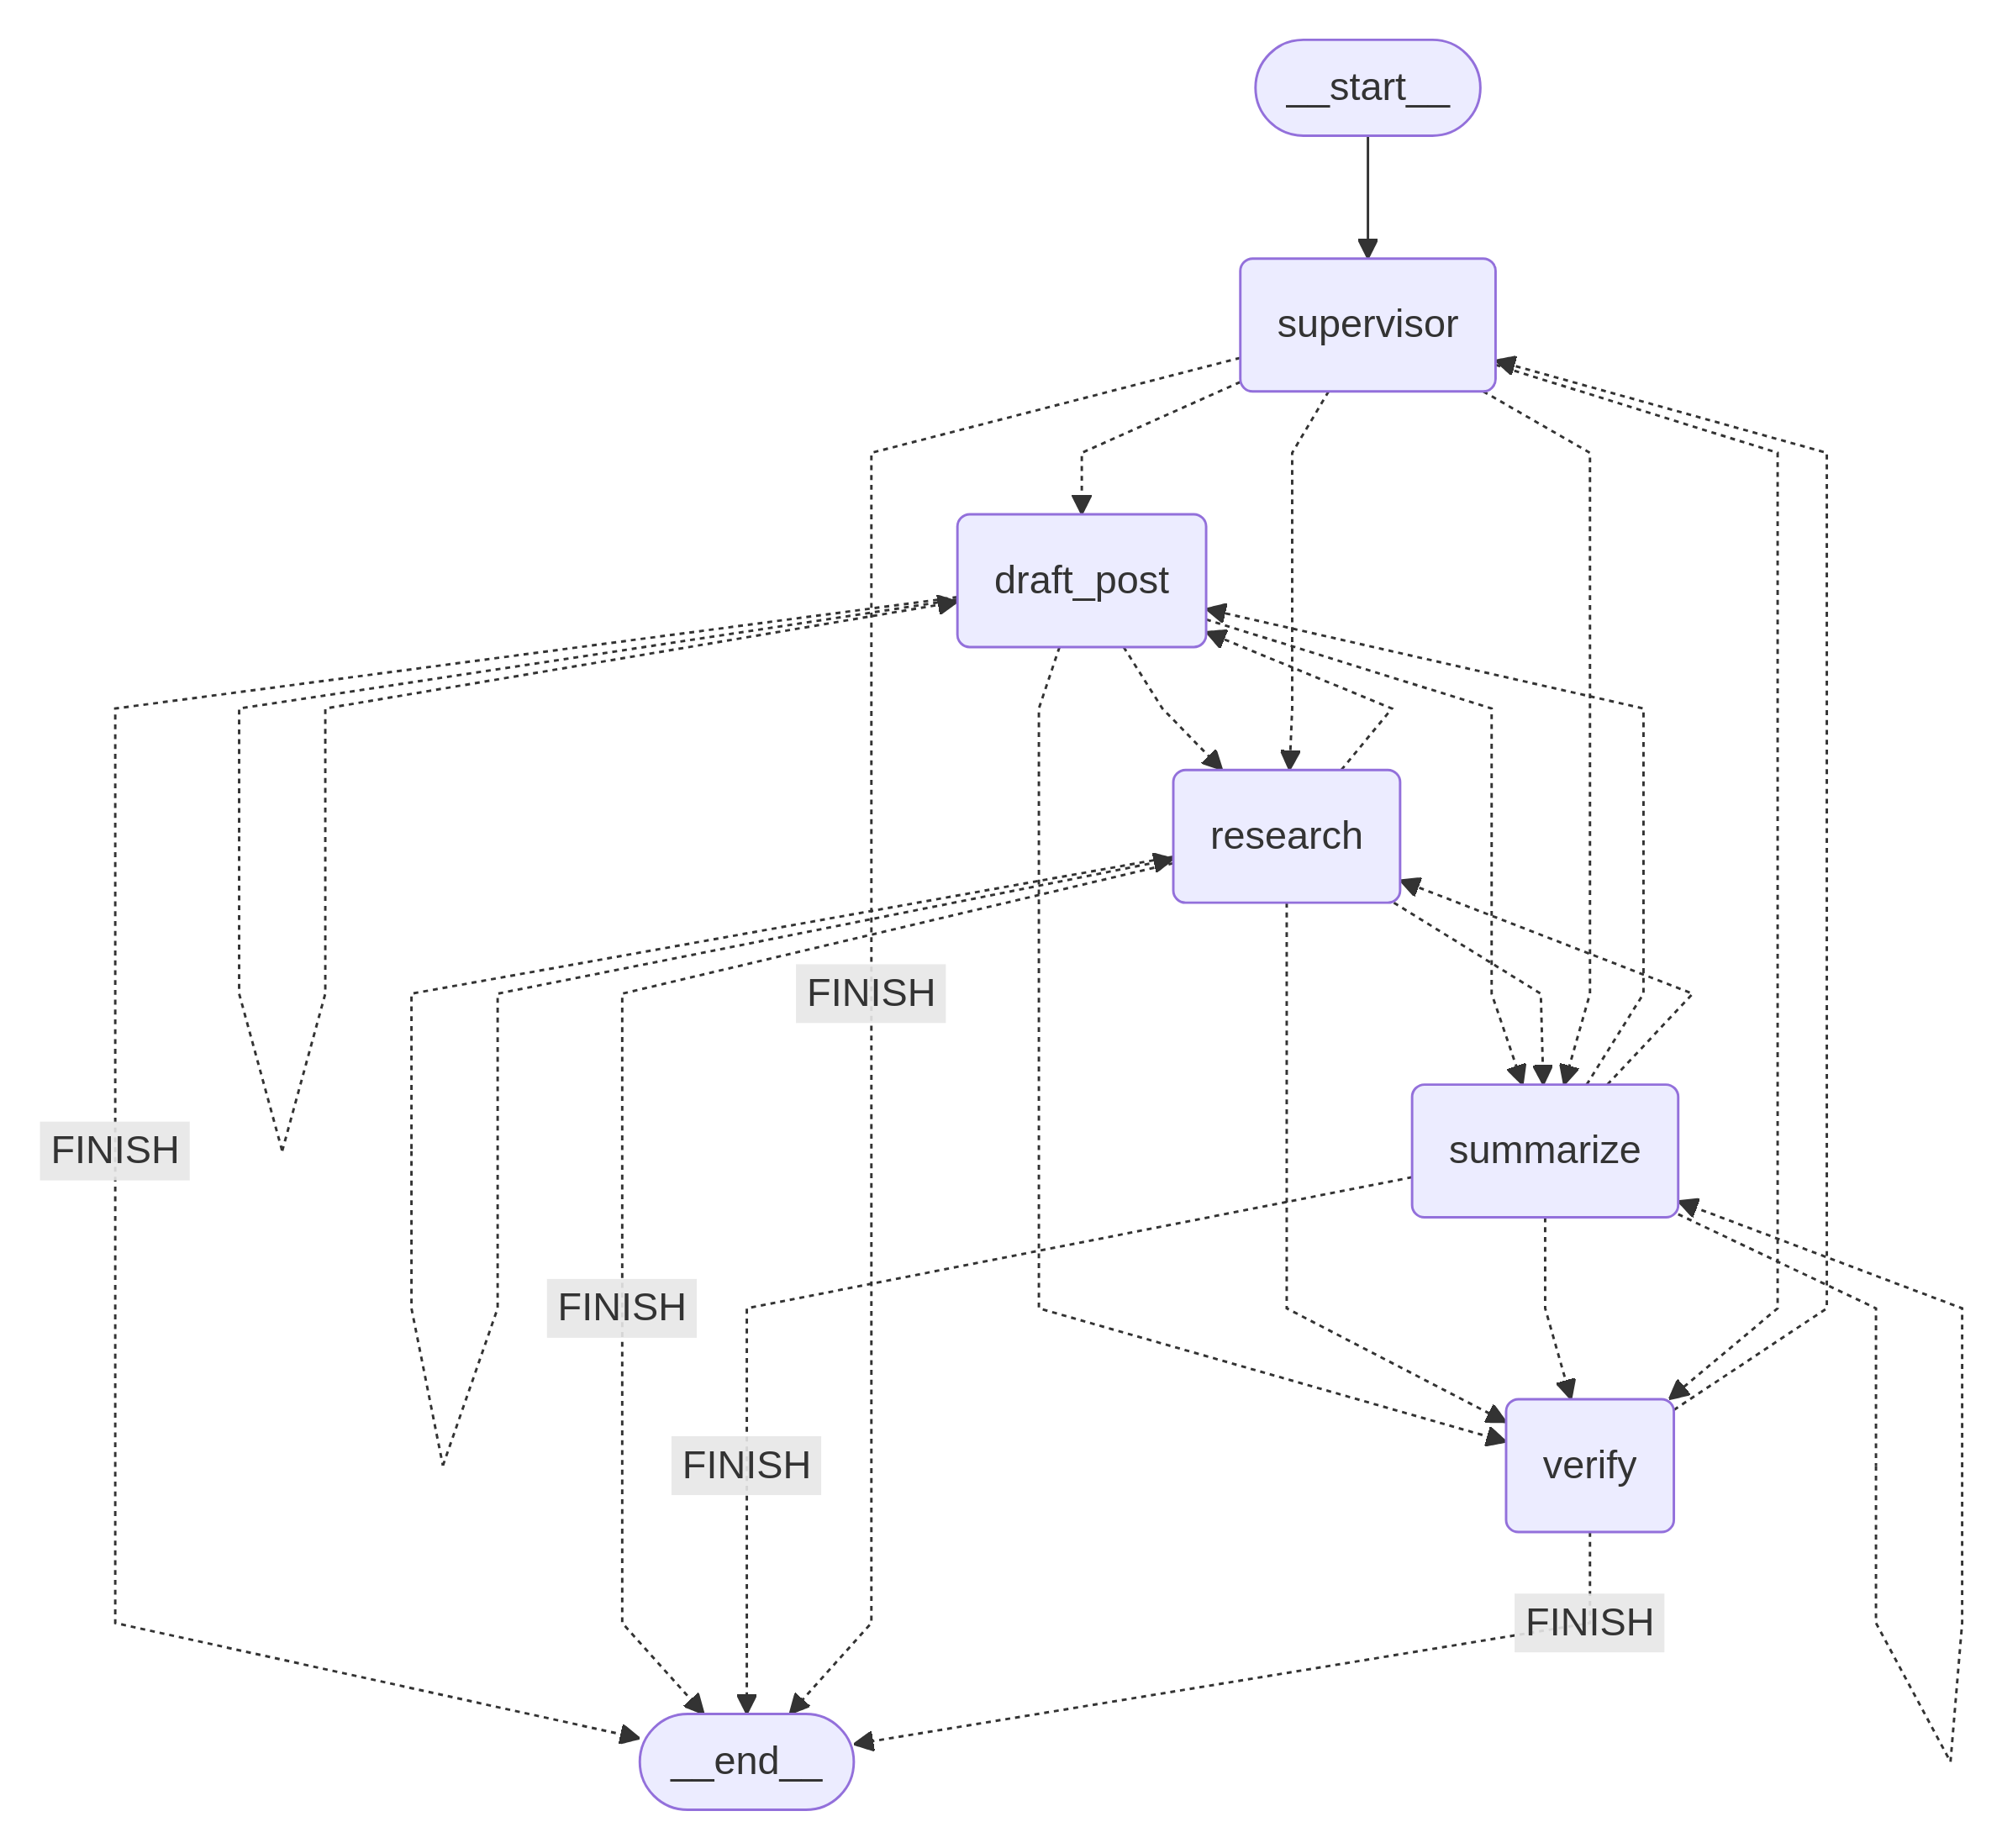

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        supervisor_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)


In [ ]:
# 8. Run Supervisor Graph
paper_title = "LoRA: Low-Rank Adaptation of LLMs"
input_messages = [
    HumanMessage(content=f"Please write a LinkedIn post about the paper '{paper_title}'")
]

print("🎯 Running Supervisor-Coordinated Multi-Agent System...")
print("=" * 60)

result = supervisor_graph.invoke({
    "messages": input_messages, 
    "revision_count": 0,
    "summary": "",
    "post": "",
    "verify_result": "",
    "tech_check": "",
    "style_check": "",
    "next_agent": ""
})

print("✅ Final Output:")
print("=" * 60)
for m in result["messages"]:
    print(f"📝 {m.content}")

print(f"\n📄 Summary:\n{result.get('summary', 'N/A')}")
print(f"\n📝 Post:\n{result.get('post', 'N/A')}")
print(f"\n🔍 Verify Result: {result.get('verify_result', 'N/A')}")
print(f"\n🔁 Number of Revisions: {result.get('revision_count', 0)}")
print(f"\n🔬 Technical Check: {result.get('tech_check', 'N/A')}")
print(f"🎨 Style Check: {result.get('style_check', 'N/A')}")
print(f"\n🎯 Next Agent Decision: {result.get('next_agent', 'N/A')}")

🎯 Running Supervisor-Coordinated Multi-Agent System...


/tmp/ipykernel_52121/4148327156.py:10: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent_func(state)
